# 과제 - 5주차

## 다운로드, 정제, 저장을 하나의 task로 작성할지, 별도의 task 를 두고 dependency 를 설정할지 결정해보세요

* 아래의 Task로 구분해서 진행
  * 다운로드
  * 오래된 파일 삭제
  * 정제 및 저장
* Dependency는 원본 파일의 다운/삭제가 완료된 후에 정제/저장이 되도록 설정

## 데이터 다운로드, 정제, 저장 기능을 수행하는 DAG 를 작성하고 스케줄링을 적용해보세요

### 진행방안
* 파일에 대한 작업을 먼저 진행한 뒤 Slack으로 결과 전송
  * 다운로드와 삭제는 어느 것이 먼저 진행되어도 무방
  * 다운로드와 삭제함수가 내역을 리턴하고, Slack이 해당 내용으로 작업완료 알림
  
* Spark로 데이터를 정제한 뒤 저장하고, Slack으로 결과 전송
  * 데이터를 정제한 뒤 저장하고, Text파일로 Dataframe결과표를 저장
  * Text파일의 표를 Slack으로 전송하여 작업결과를 공유
  
### Airflow Graph

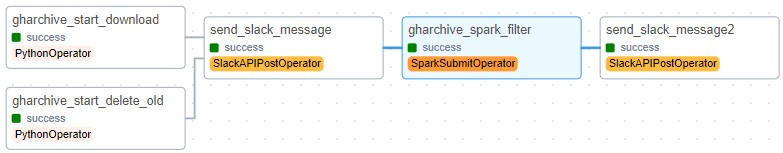

### Slack 결과 샘플

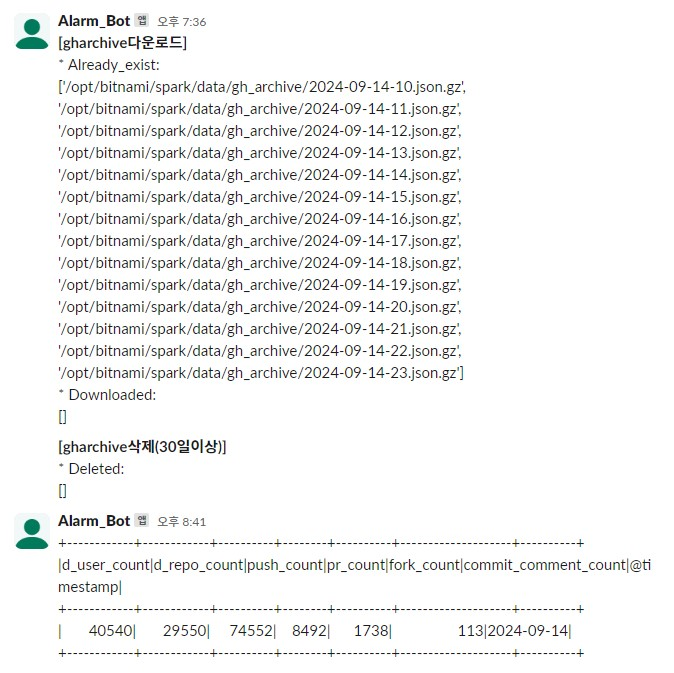

### 코드

In [ ]:
from airflow import DAG
from airflow.operators.python import PythonOperator
from airflow.providers.apache.spark.operators.spark_submit import SparkSubmitOperator
from airflow.providers.slack.operators.slack import SlackAPIPostOperator
from datetime import datetime, timedelta

import sys
sys.path.append('/opt/airflow/jobs')
from airflowjob_down_new_delete_old import down_from_gharchive, del_old_file_gharchive

# DAG
dag = DAG("gharchive-down_new_delete_old", 
          default_args={
            "owner": "airflow",
            "depends_on_past": False, # 과거 실행에 의존
            "start_date": datetime(2024, 9, 8),
            "retries": 1,             # retry 횟수
            "retry_delay": timedelta(minutes=3), # retry주기
            },
          catchup=False, 
          tags=['PKB','gharchive','down&delete'])


# Task1 : 다운로드
target_date_down = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
target_path = '/opt/bitnami/spark/data/gh_archive/'
download_from_gharchive = PythonOperator(
    task_id="gharchive_start_download",
    op_kwargs={"target_date_down": target_date_down,"target_path":target_path},
    python_callable = down_from_gharchive,
    dag=dag
)

print(download_from_gharchive)

# Task2 : 1달지난 파일 삭제
target_date_delete = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')
delete_old_of_filepath = PythonOperator(
    task_id="gharchive_start_delete_old",
    op_kwargs={"target_date_delete": target_date_delete,"target_path":target_path},
    python_callable = del_old_file_gharchive,
    dag=dag
)

# Task3 : 결과 전송 with Slack (위 Task에서 리턴받은 결과를 출력)
send_result_with_slack = SlackAPIPostOperator(
    slack_conn_id="slack_pkb",
    task_id='send_slack_message',
    channel='#alarm',  # 전송할 Slack 채널
    dag=dag,
    blocks=[
        {
            "type": "section",
            "text": {
                "type": "mrkdwn",
                "text": (
                    "*[gharchive다운로드]*\n{{ task_instance.xcom_pull(task_ids='gharchive_start_download') }}\n\n"
                    "*[gharchive삭제(30일이상)]*\n{{ task_instance.xcom_pull(task_ids='gharchive_start_delete_old') }}"
                ),
            },
        }
    ],
    text="Fallback message",  # 필수 fallback 메시지
)


# Task4 : Spark 데이터 정제
spakr_filter_gh = SparkSubmitOperator(
        task_id='gharchive_spark_filter',
        application="jobs/main.py", # 절대경로라면 /opt/airflow/jobs/main.py
        name="spark_filter_gh",
        conf={
            'spark.master': 'spark://spark-master:7077',  # master 설정
            'spark.dynamicAllocation.enabled': 'true',
            'spark.dynamicAllocation.executorIdleTimeout': '2m',
            'spark.dynamicAllocation.minExecutors': '1',
            'spark.dynamicAllocation.maxExecutors': '3',
            'spark.dynamicAllocation.initialExecutors': '1',
            'spark.memory.offHeap.enabled': 'true',
            'spark.memory.offHeap.size': '2G',
            'spark.shuffle.service.enabled': 'true',
            'spark.executor.memory': '2G',
            'spark.driver.memory': '2G',
            'spark.driver.maxResultSize': '0',
        },
        conn_id="spark-conn", # 필수값. UI에서 conenctivity 설정해둔 기준
        jars="/opt/bitnami/spark/resources/elasticsearch-spark-30_2.12-8.4.3.jar",
        executor_cores=1,
        num_executors=2,
        verbose=1,
        dag=dag
    )

# Task5 : 결과 전송 with Slack
def read_spark_output(**kwargs):
    with open("jobs/output.txt", "r") as f:
        output = f.read()
    return output  # Store the output in XCom

send_result_with_slack2 = SlackAPIPostOperator(
    slack_conn_id="slack_pkb",
    task_id='send_slack_message2',
    channel='#alarm',  # 전송할 Slack 채널
    dag=dag,
    blocks=[
        {
            "type": "section",
            "text": {
                "type": "mrkdwn",
                "text": read_spark_output(),
            },
        }
    ],
    text="Fallback message",  # 필수 fallback 메시지
)

[download_from_gharchive, delete_old_of_filepath] >> send_result_with_slack >> spakr_filter_gh >> send_result_with_slack2